## Please install these extensions before running the code below

In [119]:
#pip install
print("Downloading..")
print("Wait awhile ah.....")
!pip install folium 
print("Almost done! Relac......")
!pip install wordcloud
nltk.download('wordnet')
print("Last one i promise")
nltk.download('punkt')    
print("Downloads complete.")

Downloading..
Wait awhile ah.....
Almost done! Relac......
Last one i promise
Downloads complete.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kwcheng\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kwcheng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<center><h1>What makes a good wine?</h1></center>

### Data Source(s)
 
- Wine Review, [https://www.kaggle.com/zynicide/wine-reviews]
- World countries coordinates(JSON), [https://github.com/python-visualization/folium/blob/master/examples/data/world-countries.json]
- Wine photo - [http://www.imagefast.org/wine-bottle-silhouette-png/] (if you cannot access the link, copy and paste it to a browser manually)

##### Wine review Columns:
- designation: The vineyard within the winery where the grapes that made the wine are from
- points: The quality of wine rated by WineEnthusiast on a scale from 1-100, 100 being the best
- price: The cost for a bottle of the wine
- state: The province or state that the wine is harvested 
- region: The province or state (ie Napa) where the winery is located
- variety: The type of grapes used to make the wine (ie Pinot Noir)
- winery: The winery that made the wine

<hr>

## Executive Summary

This report provides an analysis and evaluation on what makes a good and tasty wine, whether quality wine comes with a heavy price tag. Method of analysis include trend, horizontal and vertical analyses as well as correlation analysis, Pearson correlation between prices and points. Results of data analysed show that prices and points are correlated with moderate strength according to the pearson correlation coefficient and significant value, also known as the p-value. In addition, the mean ratings of wine from various countries shows the most frequency highest point wines came from US, Italy and France. After further analysis, the wines produced from different countries holds different wine characteristics for example, wines from US tend to be more rich and fruity in flavor while wines from Italy/Spain are sweeter due to it's composition. 


### Introduction

As a group of wine enthusiasts, we aspire to bring to light the characteristics of good wine. In doing so, we will be scrutinizing certain determinants hypotesised to implicate the quality of wine. The factors are product price, ratings and location of winery. To further expand our research, we will also be exploring the possiblity of predicting wine quality before it is matured.

Scope of study:

- Where does good wine come from(country/designation)?
- Higher the price corresponds to tastier wine?
- Can we predict the rating of a wine by description? 

### Why this topic?

The reason behind this research study is because there are many different types of wine around the world. It is difficult to pinpoint which wine is the best of it's kind due to individual preferences. Thus we chose this topic so that we can determine the different characteristics good wines for consumers to make better decisions.



### Methodology

#### Cleaning up data
In this section, the columns not required are removed and any data with null value in the rows were also removed using dropna().
1. [Importing and cleanup Data](#Importing-and-cleanup-Data)

#### Comparing data with countries and points
Looking at different countries and the points collected, we managed to plot a map showcasing the average points of wines for each country
2. [Country with the highest number of 100 points wines](#Country-with-the-highest-number-of-100-points-wines)
3. [Map with Mean ratings of wine](#Map-with-Mean-ratings-of-wine(Folium))

#### Comparing data with points and prices
In this segment, the pearson correlation is used to determine the relationship between prices and points as well as the strength of the said relationship. We also studied the skewness of the variables using boxplot
4. [Higher price corresponds to high ratings wine?](#Does-higher-price-corresponds-to-high-ratings-wine?)

##### Machine Learning
We further the study by creating a machine learning model to study the descriptions of each wine which predict the points.
5. [Understanding wine description with NBClassifier](#Understanding-wine-description-with-Naive-Bayes-Classification-Algorithm)
6. [Understanding wine description by countries with DecisionTree](#Understanding-wine-description-by-countries-with-DecisionTree)
7. [Feature Importance with DecisionTree](#Feature-Importance-with-DecisionTree)

##### Word Cloud
Examining the description from various country's wine and uncovering the max common words appeared using a Word cloud
8. [Understanding wine description with wordcloud](#Understanding-wine-description-with-wordcloud)

Lastly, [Conclusion](#Conclusion)

#### Extra feature: 

 - [Predicting description](#Testing-out-machine-learning-model-with-input-description)

In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import folium
import scipy
import re
from os import path
from PIL import Image

#NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, wordnet
from nltk.tokenize import word_tokenize

#SKLEARN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import entropy
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.metrics import accuracy_score

#Word Cloud
from wordcloud import WordCloud

#Stats
from statistics import mean
from scipy import stats

%matplotlib inline

### Importing and cleanup Data


In [358]:
wine_df = pd.read_csv("winemag-data-130k-v2.csv")
json_data = json.load(open("world-countries.json"))

wine_df = wine_df.drop(columns = ['taster_twitter_handle', 'taster_name', 'region_2', 'Unnamed: 0', 'title'])
wine_df['country'].replace({'US': 'United States of America'}, inplace= True)
clean_wine = wine_df.dropna(axis = 0) # Keeping data with information and removing any rows that have "NaN"
clean_wine.reset_index(drop= True, inplace= True)

new_names = {
     'region_1': 'region',
     'province' : 'state' 
}


cleaned_wine = clean_wine.rename(new_names, axis='columns')

In [359]:
cleaned_wine.head()

,country,description,designation,points,price,state,region,variety,winery
0,United States of America,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Riesling,St. Julian
1,United States of America,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Pinot Noir,Sweet Cheeks
2,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Tempranillo-Merlot,Tandem
3,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Frappato,Terre di Giurfo
4,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Pinot Gris,Jean-Baptiste Adam


### Country with the highest number of 100 points wines



In [360]:
sorted_cleaned_wine = cleaned_wine.sort_values(by='points',ascending=False)

wine_max_points = sorted_cleaned_wine[sorted_cleaned_wine['points'] == 100]
wine_max_points = wine_max_points.groupby(['country']).agg({
    'points':'size'
})

wine_max_points = wine_max_points.reset_index().rename({'points':'Wines with 100pts'}, axis = 'columns')
wine_max_points



,country,Wines with 100pts
0,Australia,1
1,France,3
2,Italy,4
3,United States of America,3


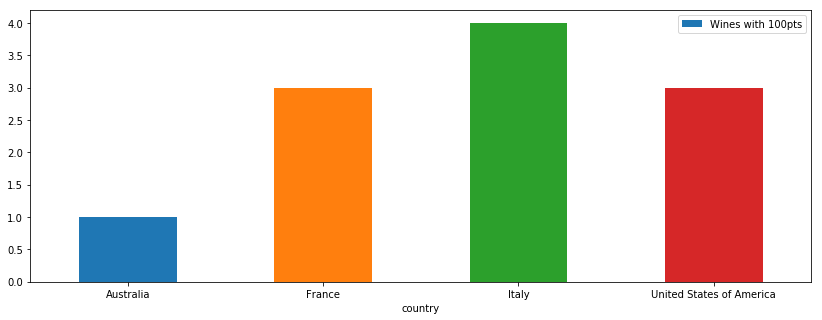

In [361]:
fig = plt.figure(figsize = (14,5))
ax = fig.add_subplot(111)

wine_max_points.plot(kind = "bar", y = "Wines with 100pts", x = "country", ax = ax, rot=0)

Insights: From the table/graph above we can observe that, the highest count of 100 points wine can be found in Italy. However, we cannot conclude that "Country" is the only factor that determines the quality of wine.

#### What is the highest price wine of the countries (Argentina, Australia, Canada, France, Italy, Spain, US)?

Text(0, 0.5, 'Price')

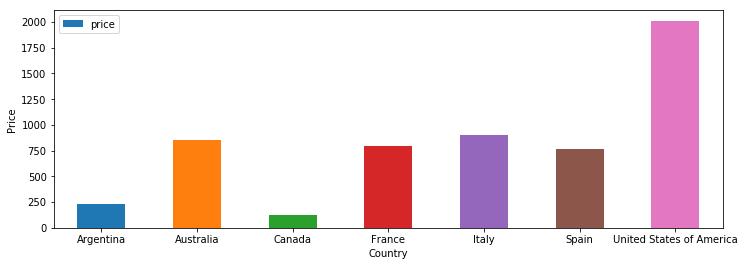

In [362]:
max_price_country = cleaned_wine.groupby(['country']).agg({
    'price': 'max'
})
max_price_country.reset_index(inplace = True)
fig = plt.figure(figsize = (12,4))
ax1 = fig.subplots()

max_price_country.plot(kind='bar',x='country',y='price',ax = ax1, rot=0)

#Label
ax1.set_xlabel('Country')
ax1.set_ylabel('Price')

### Map with Mean ratings of wine(Folium)

From the map below we can observe that most of the high rating wines comes from with wines coming from different countries.


In [363]:
wine_state_pt = sorted_cleaned_wine.groupby(['country']).agg({
    'points' : 'mean'
})
wine_state_pt.reset_index(inplace=True)
wine_state_pt['country'].unique()



array(['Argentina', 'Australia', 'Canada', 'France', 'Italy', 'Spain',
       'United States of America'], dtype=object)

#### Mean ratings of wines produced in different countries

In [364]:
wine_state_pt

,country,points
0,Argentina,87.141085
1,Australia,89.003713
2,Canada,89.363636
3,France,89.077831
4,Italy,88.839055
5,Spain,87.465994
6,United States of America,89.017671


In [365]:
m = folium.Map([0,0], zoom_start= 1.5)

m.choropleth(geo_data=json_data, data=wine_state_pt,
             columns=['country', 'points'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.4, line_opacity=0.2,
             legend_name='Mean rating of wine')

data = pd.DataFrame({
'lat':[-65, -53, 2, 135, -3, 12, -101, -101],
'lon':[-34, 4, 46.7, -24, 40.5, 43, 66, 40],
'name':['Argentina', 'Guyane', 'France', 'Australia', 'Spain', 'Italy', 'Canada', "United States of America"]
})

for i in range(0,len(data)):
    folium.Marker([data.iloc[i]['lon'], data.iloc[i]['lat']], popup=data.iloc[i]['name']).add_to(m)

folium.LayerControl().add_to(m)

m

C:\Users\kwcheng\AppData\Local\Continuum\anaconda3\lib\site-packages\folium\folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Insights: Based on the output generated, it can be observed that the darkest shades amalgamate 4 main regions namely the US, Canada, France and Australia. They range between 87 to 89 points. 

### Does higher price corresponds to high ratings wine?

In this section, we will be adopting the Pearson correlation to observe the relationship between points and prices of the various wines. Using df.corr() and scipy.stats.pearsonr

In [366]:
cleaned_wine_corr = cleaned_wine.corr()
print("Correlation: \n")
print(cleaned_wine_corr, "\n")
print("The pearson correlation coefficient:", cleaned_wine_corr['price'].iloc[0])

Correlation: 

          points     price
points  1.000000  0.462413
price   0.462413  1.000000 

The pearson correlation coefficient: 0.4624125311166409


In [367]:
corr_pvalue = scipy.stats.pearsonr(cleaned_wine['price'],cleaned_wine['points'])

print("The pearson correlation coefficient:",corr_pvalue[0])
print("The p-value:",corr_pvalue[1])

The pearson correlation coefficient: 0.4624125311166528
The p-value: 0.0


###### Since the p-value is 0, it implies that the correlation is highly significant.

#### Removing outliers from the study 

To get a more accurate reflection of the actual correlation, we removed a set of outliers from the dataset.

In [368]:
p25 = np.percentile(cleaned_wine['price'], 25)
p75 = np.percentile(cleaned_wine['price'], 75)

iqr =  p75 - p25
lowerbound = p25 - (iqr*1.5)
upperbound = p75 + (iqr*1.5)

cleaned_wine_no_outliers = cleaned_wine[(cleaned_wine['price'] > lowerbound) & (cleaned_wine['price'] < upperbound)]


#### Plot with Outliers

0.03961993353765018 87.23901567542674


Text(0.5, 1.0, 'Pearson Correlation: 0.4624125311166409')

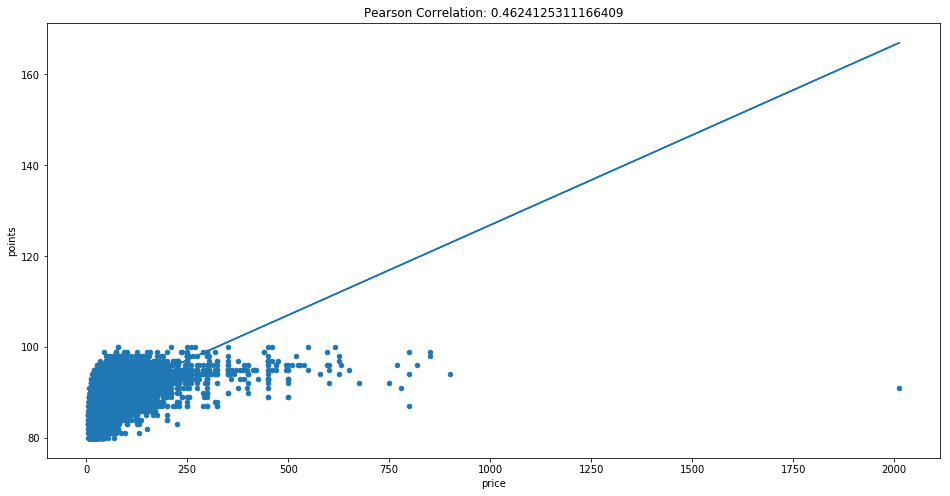

In [369]:
def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs) * mean(ys)) - mean(xs*ys))/ ((mean(xs)*mean(xs)) - mean(xs*xs)))
    b = mean(ys) - m*mean(xs)
    return m, b

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(111)
xs = cleaned_wine['price']
ys = cleaned_wine['points']

#Regression line
    
m,b = best_fit_slope_and_intercept(xs,ys)
# m = best fit slope
# b = best fit y-intercept
print(m,b)

regression_line_y = [(m*x)+b for x in xs]

#Plot with outliers
cleaned_wine.plot(kind='scatter', x= 'price', y='points', ax = ax1)
plt.plot(xs, regression_line_y)
ax1.set_title('Pearson Correlation: 0.4624125311166409')

#### Plot without Outliers

0.08506057744833767 85.72168300407053


Text(0.5, 1.0, 'Pearson Correlation: 0.4624125311166409')

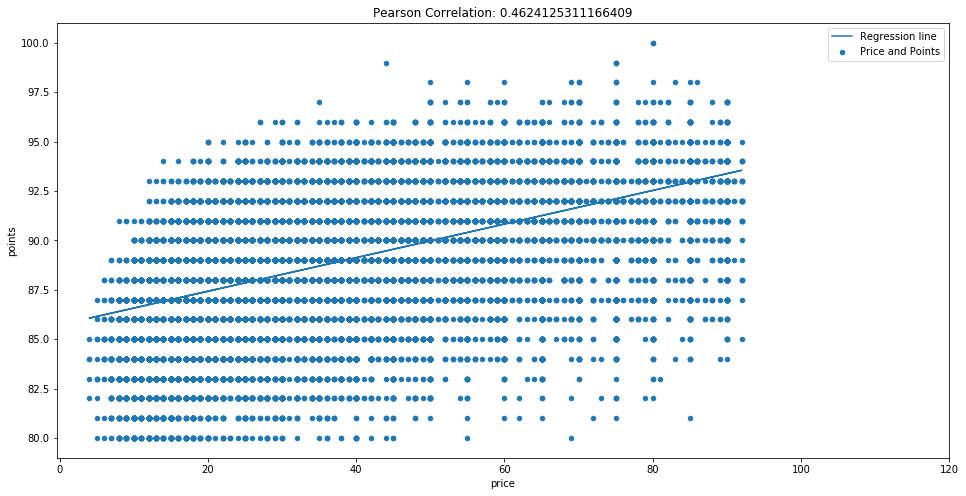

In [370]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(111)


xs = cleaned_wine_no_outliers['price']
ys = cleaned_wine_no_outliers['points']

#Regression line

m,b = best_fit_slope_and_intercept(xs,ys)
print(m,b)

regression_line_y = [(m*x)+b for x in xs]

#Plot without outliers
cleaned_wine_no_outliers.plot(kind='scatter', x= 'price', y='points', ax = ax1)
plt.plot(xs, regression_line_y)

#Label
ax1.legend(['Regression line','Price and Points'])
ax1.set_xticks(range(0,140,20))
ax1.set_title('Pearson Correlation: 0.4624125311166409')

The coefficient indicates a positive correlation with a moderate strength of 0.462. This implies that as price of wine increases, the number of points scored increases as well.

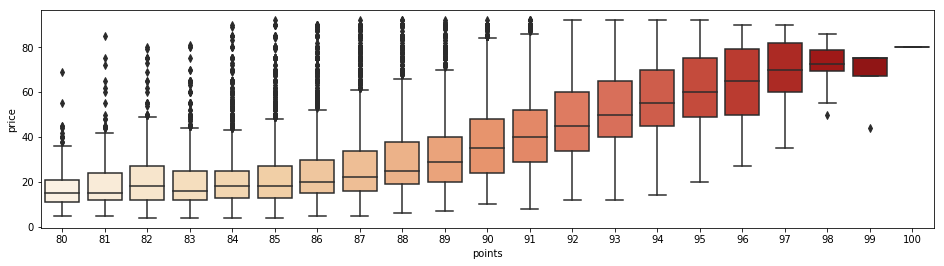

In [371]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(111)

sns.boxplot(x= 'points', y='price', data = cleaned_wine_no_outliers, ax = ax, palette = 'OrRd')

Observation: As the price increases, the median increases. This indicates a positive correlationship between both prices and points.In addition, the data generally portrays a right tailed skewness(positive) which shows that the mean is generally higher than the median.

### Understanding wine description with Naive Bayes Classification Algorithm

In this machine learning model, it is able to predict the points of a wine from a description.

In [372]:
rating_description = sorted_cleaned_wine[['description','points']]
rating_description.head()

,description,points
63740,This wine dazzles with perfection. Sourced fro...,100
21184,"A perfect wine from a classic vintage, the 200...",100
61456,In 2005 Charles Smith introduced three high-en...,100
48418,This new release from a great vintage for Char...,100
48417,This latest incarnation of the famous brand is...,100


##### Train data

In [373]:
X = rating_description['description']
y = rating_description['points']

#Split the data in to train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

In [374]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(52631,)
(52631,)
(17544,)
(17544,)


In [375]:
count_vect = CountVectorizer(stop_words = stopwords.words("english"))
count_vect.fit(X_train)
X_train_vectorized = count_vect.transform(X_train)
X_train_vectorized

#Fit to NB Classification
clf = MultinomialNB()
clf.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Test data

In [376]:
X_test_vectorized = count_vect.transform(X_test)
y_predict = clf.predict(X_test_vectorized)

X_test_vectorized

<17544x22127 sparse matrix of type '<class 'numpy.int64'>'
	with 445061 stored elements in Compressed Sparse Row format>

In [377]:
tested_df = pd.DataFrame({
    'Description' : X_test,
    'points': y_test,
    'predicted points' : y_predict
})

tested_df['Description'].head(1)

13468    This opens with hushed scents of dark berry, b...
Name: Description, dtype: object

#### Evaluating the effectiveness of the model

In [378]:
# (Total number of points = predicted points)/ (Total tested data)

success_rate = accuracy_score(y_test, y_predict) *100
print("The success rate of using this model is", success_rate,"%")

The success rate of using this model is 23.09621523027816 %


#### Evaluating the effectiveness of the model with a tolerence of +/- 1 

After implementing a tolerance of +/- 1, the overall success rate when using this machine learning model increases close to 200%.

In [379]:
pts_and_predict = tested_df.drop(columns = 'Description')
pts_and_predict['points']

def tolerence(pts_and_predict):
    if (pts_and_predict['points'] - 2) < pts_and_predict['predicted points'] < (pts_and_predict['points'] + 2):
        return True
    else:
        return False
    
pts_and_predict = pts_and_predict[pts_and_predict.apply(tolerence, axis = 1)]

success_rate_tolerence_1 = (len(pts_and_predict)/ len(tested_df)) * 100

print("The success rate of using this model is", success_rate_tolerence_1,"%")

The success rate of using this model is 54.29206566347469 %


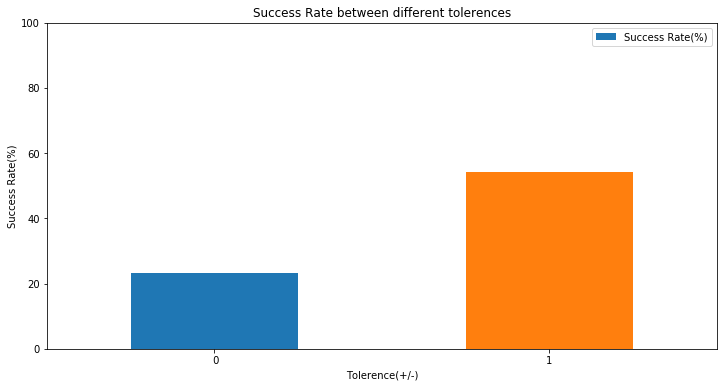

In [380]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)


success_graph = pd.DataFrame({
    'Tolerence(+/-)':[' 0', '1'],
    'Success Rate(%)' : [round(success_rate,2),round(success_rate_tolerence_1,2)] 
})

success_graph.plot(kind='bar', x='Tolerence(+/-)', y='Success Rate(%)', ax= ax, rot=0)

#label
ax.set_title("Success Rate between different tolerences")
ax.set_xlabel("Tolerence(+/-)")
ax.set_ylabel("Success Rate(%)")
ax.set_yticks(range(0,101,20))
plt.show()

In terms of accuracy, the Naive Bayes classification was able to predict the rating of wines within a tolerence of +/- 1 point with a success rate of 54.29%. However, the success rate for the model to predict the exact score are compromised to 23.09% close to 2 times increase in accuracy due to inevitable factors such as individual differences. 

Taking this into account, we considered to include a certain level of tolerance when predicting the score to minimize sampling error.

### Understanding wine description by countries with DecisionTree

#### Encoding

Encoded the list of countries before applying the DecisionTreeClassifier model


In [381]:
dv_X = DictVectorizer(sparse = False)
country_list = ['Argentina','Australia', 'Canada', 'France', 'Italy', 'Spain', 'United States of America' ]
features_list = ['country']
X = cleaned_wine[features_list]
y = cleaned_wine['points']

X_dict = X.to_dict(orient='records')
X_limit = X_dict
y_limit = y

In [382]:
X_encoded = dv_X.fit(X_limit)

In [383]:
X_encoded =dv_X.transform(X_limit)

In [384]:
X_encoded

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [385]:
vocab = dv_X.vocabulary_
vocab

{'country=Argentina': 0,
 'country=Australia': 1,
 'country=Canada': 2,
 'country=France': 3,
 'country=Italy': 4,
 'country=Spain': 5,
 'country=United States of America': 6}

#### Test Split

In [386]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_limit, test_size = 0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(52631, 7)
(17544, 7)
(52631,)
(17544,)


#### Train

In [387]:
dtree = DecisionTreeClassifier(criterion = "entropy",random_state=0)
dtree.fit(X_train,y_train)
dtree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

#### Test

In [388]:
y_pred = dtree.predict(X_test)

print(accuracy_score(y_test, y_pred) * 100 ,'%')

13.155494756041952 %


### Feature Importance with DecisionTree

In [389]:
print("Feature importances:\n{}".format(dtree.feature_importances_))


Feature importances:
[0.29527719 0.01126262 0.         0.08104137 0.27179662 0.31462129
 0.02600091]


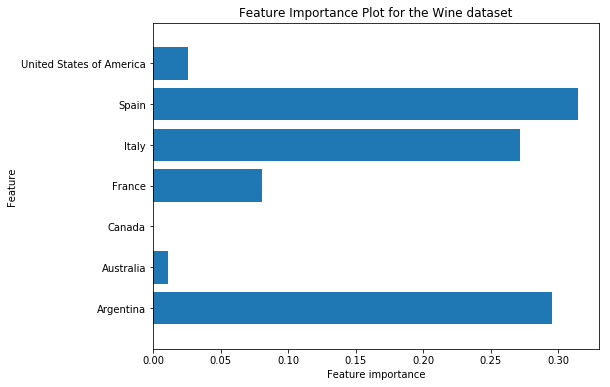

In [390]:
n_features = 7

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

plt.barh(range(n_features), dtree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), labels = country_list)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Feature Importance Plot for the Wine dataset")
plt.ylim(-1, n_features)
plt.show()


In terms of importance, Spain being most important followed by Argentina, Italy, France, US and lastly Australia. 

#### Testing out machine learning model with input description

In [391]:
input_description = input("Please enter your description: ")

description = pd.DataFrame({"Description": [input_description]})

X_test_vectorized = count_vect.transform(description)
y_predict = clf.predict(X_test_vectorized)


y_predict

Please enter your description: 


array([87], dtype=int64)

### Understanding wine description with wordcloud

In [392]:
wine_mask = np.array(Image.open("wine glass.png"))

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
transformed_wine = np.ndarray((wine_mask.shape[0],wine_mask.shape[1]), np.int32)

for i in range(len(wine_mask)):
    transformed_wine[i] = list(map(transform_format, wine_mask[i]))

In [393]:
lemmatizer = WordNetLemmatizer()
sno = nltk.stem.SnowballStemmer('english')
wine_word = sorted_cleaned_wine[:300]
wine_word = wine_word[['description','points']]
wine_dict = wine_word.to_dict(orient = 'list')
wine_description_list = wine_dict['description']

wine_list = []
pat = r"[\.,/';\[\]{}:\"'\(*&^%$#@\)!\n]"

for i in range(0,len(wine_description_list)):
    lower_wine_description = wine_description_list[i].lower()
    wine_description_list_sub = re.sub(pat, " ", lower_wine_description)
    wine_list.append(wine_description_list_sub)
    i+=1

In [394]:
wine_lammatize = []
final_words = []

for s in wine_list:
    for st in word_tokenize(s):
        wine_lammatize.append(lemmatizer.lemmatize(st))

for lam in wine_lammatize:
    if lam not in stopwords.words('english'):
        final_words.append(lam)
        
    
final_string = " "
for string in final_words:
    final_string = final_string + " " + string


##### Normal Wordcloud display without masking

In [402]:
# fig = plt.figure(figsize=(10,7))

# description_cloud = WordCloud(
#     width=400, height=150,
#     background_color="white", 
#     max_words=200, relative_scaling = 1).generate(final_string)


# plt.imshow(description_cloud,interpolation='bilinear')
# plt.axis("off")
# plt.title("Wordcloud of top 300 wines", fontsize=15)
# plt.show()

 ### Description of the top 300 wines

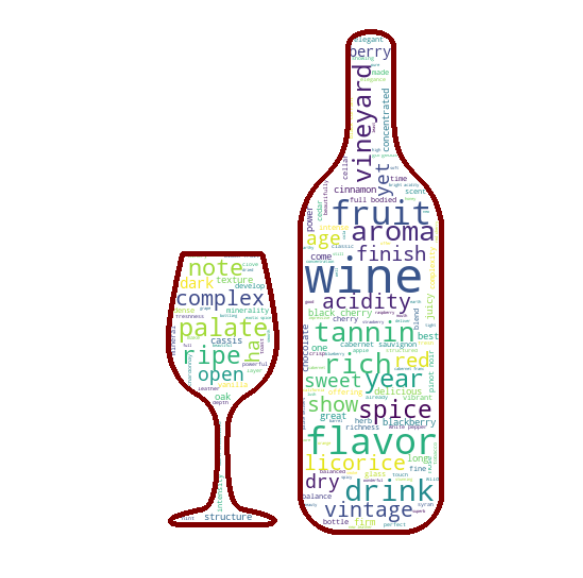

In [396]:
wc = WordCloud(background_color="white", 
            max_words=150, 
            mask=transformed_wine,
            contour_width=5, contour_color='maroon').generate(final_string)

# show
plt.figure(figsize=[15,10])
plt.imshow(wc, interpolation='bilinear') #Used bilinear for smooth text
plt.axis("off")
plt.show()

### Word clouds of wine description based on country

In [397]:
wine_word = sorted_cleaned_wine
wine_usa = wine_word[wine_word["country"]=="United States of America"].iloc[:100]
wine_fra = wine_word[wine_word["country"]=="France"].iloc[:100]
wine_ita = wine_word[wine_word["country"]=="Italy"].iloc[:100]
wine_spa = wine_word[wine_word["country"]=="Spain"].iloc[:100]

usa = " ".join(review for review in wine_usa[wine_usa["country"]=="United States of America"].description)
fra = " ".join(review for review in wine_fra[wine_fra["country"]=="France"].description)
ita = " ".join(review for review in wine_ita[wine_ita["country"]=="Italy"].description)
spa = " ".join(review for review in wine_spa[wine_spa["country"]=="Spain"].description)

### Wordcloud of top 100 Wine description from US

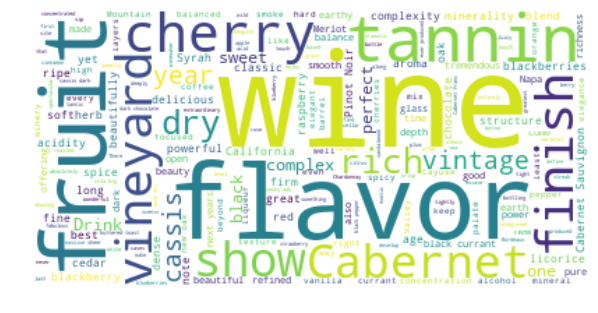

In [398]:
wordcloud_usa = WordCloud(stopwords=stopwords.words('english'), 
            background_color="white", max_words=1000).generate(usa)

plt.figure(figsize=[10,7])
plt.imshow(wordcloud_usa, interpolation="bilinear")
plt.axis("off")

plt.show()

Top words 10 from US: Wine, flavor, fruit, cabernet, cherry, vineyard, rich, tannin, chasis

### Wordcloud of top 100 Wine description from France 

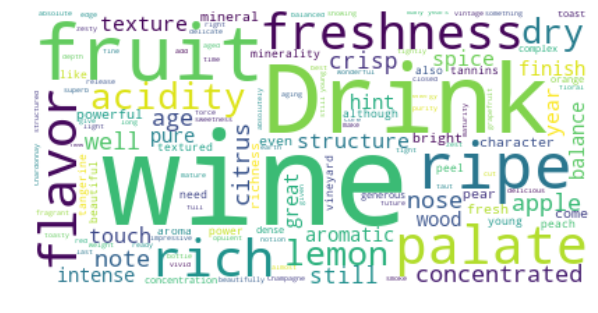

In [399]:
wordcloud_fra = WordCloud(stopwords=stopwords.words('english'), 
            background_color="white", max_words=1000).generate(fra)

plt.figure(figsize=[10,7])
plt.imshow(wordcloud_fra, interpolation="bilinear")
plt.axis("off")

plt.show()

Top 10 words from France: Drink, fruit, acidity, freshness, ripe, wine, lemon, rich, palate, flavor

### Wordcloud of top 100 Wine description from Italy 

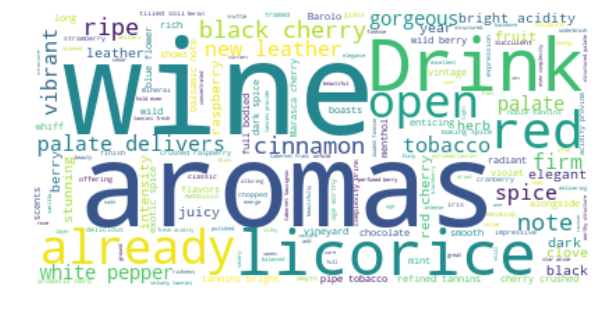

In [400]:
wordcloud_ita = WordCloud(stopwords=stopwords.words('english'), 
            background_color="white", max_words=1000).generate(ita)

plt.figure(figsize=[10,7])
plt.imshow(wordcloud_ita, interpolation="bilinear")
plt.axis("off")

plt.show()

Top 10 words from italy: Aromas, wine, licorice, cinnamon, ripe, black cherry, red, open, drink, already

### Wordcloud of top 100 Wine description from Spain

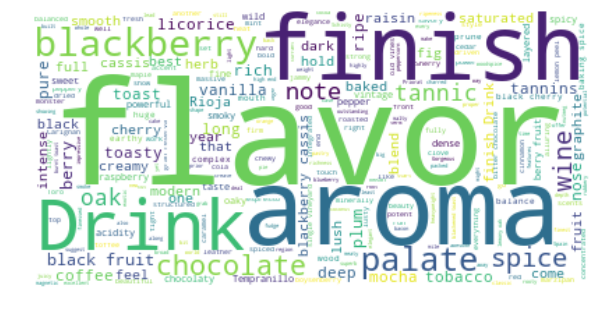

In [401]:
wordcloud_spa = WordCloud(stopwords=stopwords.words('english'), 
            background_color="white", max_words=1000).generate(spa)

plt.figure(figsize=[10,7])
plt.imshow(wordcloud_spa, interpolation="bilinear")
plt.axis("off")

plt.show()

Top 10 words from Spain: flavor, aroma, blackberry, spice, chocolate, note, wine, drink, palate

After examining the wordcloud above, we could tell that wines from US are generally more rich and fruity in flavor. Wines from France are more acidic and fresh. Also, the wines from Italy and Spain are sweet, aromatic and rich in spices, and if you are looking for any of these characteristics in a wine you should purchase wines produce from the respective countries

## Conclusion

In conclusion, based on the analysis of this study, we gain insight that the best wines (i.e. wines with the highest points) are found in Canada, France and United States of America. In addition, there is a significant positive correlationship between price and quality of wine. Therefore, we would reccommend that consumers purchase their wine either from the listed top recommended countries(based on feature importance or the country with highest mean ratings) or higher price wines. 



### Future Work

There are just boundless ways to analyze and manipulate the data set and some possible future research efforts could be performed by assigning each variety of wine to it's category of wine(E.g Red Wine, Moscato). We can further analyse and find out the good wines from the category.

In addition, we can train our machine learning model with "negative" words to predict a more accurate score of the description. Since we are only using half the the data from the dataset, we could possibly include the rest of the data and perform analysis on the missing data. 